In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import kwant

In [3]:
from scipy.constants import physical_constants

In [4]:
import pickle

In [5]:
g0 = physical_constants['conductance quantum'][0]
g0

7.748091729e-05

In [6]:
def make_syst(n_device=3):
    
    # load pseudo atomic orbital + SOC TB model for Pt conventional cell
    with open('tbmodel_pt_conv_hr.p','rb') as f:
        model = pickle.load(f)

    lattice = model.to_kwant_lattice()

    device = kwant.Builder()

    def cuboid_shape(pos):
        a,b,c = np.linalg.norm(lattice.prim_vecs,axis=1) * n_device
        x, y, z = pos
        return 0 <= x < a and 0 <= y < b and 0 <= z < c

    device[lattice.shape(cuboid_shape, (0, 0, 0))] = None
    model.add_hoppings_kwant(device)

    kwant.plot(device);

    return lattice, device.finalized()

Get system

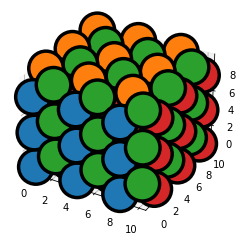

In [7]:
lattice, fsyst = make_syst(3)

Now compute the conductivity

In [8]:
where = lambda s: s.tag == [0,0,0]
s_factory = kwant.kpm.LocalVectors(fsyst, where)

In [9]:
len(s_factory.orbs), s_factory.tot_norbs

(72, 1944)

In [10]:
cond = kwant.kpm.conductivity(fsyst, alpha='x', beta='x',
                              mean=True,
                              num_moments=None, vector_factory=s_factory,
                              rng=0)

In [11]:
mu_list = np.linspace(-1,1,1001)

In [12]:
cond_array_xx = np.array([cond(mu=mu, temperature=0.01) for mu in mu_list])

Compute cell volume in Angstroms

In [13]:
vol = np.dot(np.cross(lattice.prim_vecs[0],lattice.prim_vecs[1]),lattice.prim_vecs[2])
# vol_per_site = vol / len(lattice.sublattices)
vol_per_site = (vol * 1e-30) / len(lattice.sublattices)
# vol_per_site = 1 / len(lattice.sublattices)

In [14]:
conv = vol_per_site / (g0/2)

Convert units from *volume * e^2/h* to *(Ohm * m)^-1*

should I convert Angstro^3 to m^3??

should divide by the number of lattice sites as in the example for the haldane model?

In [15]:
cond_array_xx /= conv

Plot conducivity array

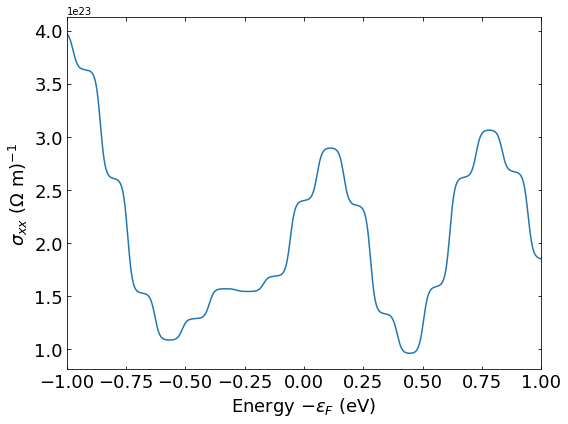

In [16]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(mu_list,cond_array_xx.real)

ax.set_xlim([mu_list.min(),mu_list.max()])

ax.set_xlabel(r'Energy $- \varepsilon_F$ (eV)',fontsize=18)
ax.set_ylabel(r'$\sigma_{xx}$ ($\Omega$ m)$^{-1}$',fontsize=18)

ax.tick_params(axis='both',direction='in',labelsize=18,bottom=True,top=True,left=True,right=True)

fig.tight_layout()

plt.show()

Get conductivity at near zero and at room temperature

In [17]:
sigma_xx = cond(mu=0, temperature=0.01) / conv

In [18]:
sigma_xx.real

2.4003200588146358e+23

In [19]:
sigma_xx_rt = cond(mu=0, temperature=293) / conv

In [20]:
sigma_xx_rt.real

1.6410046688985492e+21